In [1]:
import sys
sys.path.append('/workspace/gan/3D-FM-GAN')
from model.dataset import *
import yaml
import numpy as np
cfg = yaml.safe_load(Path("/workspace/gan/3D-FM-GAN/config/main.yaml").read_text())
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(77)
np.random.seed(77)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True

In [3]:
class IterLoader:
    def __init__(self, dataloader):
        self._dataloader = dataloader
        self.iter_loader = iter(self._dataloader)
        self._epoch = 0

    @property
    def epoch(self):
        """The number of current epoch.
        Returns:
            int: Epoch number.
        """
        return self._epoch

    def __next__(self):
        try:
            data = next(self.iter_loader)
        except StopIteration:
            print('stop iteration')
            self._epoch += 1
            if hasattr(self._dataloader.sampler, 'set_epoch'):
                self._dataloader.sampler.set_epoch(self._epoch)
            self.iter_loader = iter(self._dataloader)
            data = next(self.iter_loader)

        return data

    def __len__(self):
        return len(self._dataloader)

In [4]:
from itertools import combinations

class DisentangleDataset(Dataset):
    def __init__(self, root, sub_dir='syn_data',
                 num_variations=7,
                 crop=False,
                 resize_size=None,
                 interpolation='lanczos',
                 random_flip=False,
                 normalize=True):
        
        self.path = Path(root, sub_dir)
        self.image_path = self.path.joinpath('images')
        self.rendering_path = self.path.joinpath('rendering')
        self.mask_path = self.path.joinpath('mask')
        
        # self.id_path_list = list(Path(root, sub_dir).iterdir())
        
        self.img_p_list = list(self.image_path.rglob('*[!_r].png'))
        # self.img_r_list = sorted(list(self.rendering_path.rglob('*_r.png')))
        # self.img_m_list = sorted(list(self.mask_path.rglob('*_m.png')))
    

        self.num_variations = num_variations
        self.combi = list(combinations([i for i in range(num_variations)], 2))
        self.data_indicies = []

        # file_name
        num_total_id_imgs = len(self.img_p_list)//self.num_variations
        for i in range(num_total_id_imgs):
            subject_idx = '%05d'%(i)
            for j in self.combi:
                self.data_indicies.append([subject_idx, j[0], j[1]])


        self.interpolation = {"nearest": InterpolationMode.NEAREST,
                              "box": InterpolationMode.BOX,
                              "bilinear": InterpolationMode.BILINEAR,
                              "bicubic": InterpolationMode.BICUBIC,
                              "lanczos": InterpolationMode.LANCZOS}[interpolation]

        self.random_flip = random_flip
        self.trsf_list = []

        if crop:
            self.crop = CenterCropMargin(fraction=0.95)
            self.trsf_list.append(self.crop)
        else:
            self.crop = None    
           
        if resize_size is not None and interpolation != 'wo_resize':
            self.resizer = Resize(resize_size, interpolation=self.interpolation)
            self.trsf_list.append(self.resizer)
        else:
            self.resizer = None

        if random_flip > 0:
            self.flipper = RandomHorizontalFlip(random_flip)
            self.trsf_list.append(self.flipper)
        else:
            self.flipper = None

        if normalize:
            self.normalizer = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        else:
            self.normalizer = None
            
        self.to_tensor = ToTensor()
        self.trsf_list.append(self.to_tensor)
        
        self.trsf = transforms.Compose(self.trsf_list)

    def transformation(self, p_img, r_img, m_img):
        # p_img, r_img, m_img = self.crop(p_img), self.crop(r_img), self.crop(m_img)
        # p_img, r_img, m_img = self.resizer(p_img), self.resizer(r_img), self.resizer(m_img)
        # if self.random_flip and random.random() > 0.5:
        #     p_img = TF.hflip(p_img)
        #     r_img = TF.hflip(r_img)
        #     m_img = TF.hflip(m_img)

        # p_img, r_img, m_img = self.to_tensor(p_img), self.to_tensor(r_img), self.to_tensor(m_img)
        # return self.normalizer(p_img), self.normalizer(r_img), self.normalizer(m_img)
        data = {'p_img' : p_img, 'r_img' : r_img, 'm_img' : m_img}
        return self.trsf(data)
            
    def __len__(self):
        return len(self.data_indicies)

    def __getitem__(self, idx):

        subject_idx, first_idx, second_idx = self.data_indicies[idx]

        p1_name = f'{subject_idx}_{first_idx}.png'
        r1_name = f'{subject_idx}_{first_idx}_r.png'
        m1_name = f'{subject_idx}_{first_idx}_m.png'
        
        p2_name = f'{subject_idx}_{second_idx}.png'
        r2_name = f'{subject_idx}_{second_idx}_r.png'
        m2_name = f'{subject_idx}_{second_idx}_m.png'

        p1_path = self.image_path.joinpath(p1_name)
        r1_path = self.rendering_path.joinpath(r1_name)
        m1_path = self.mask_path .joinpath(m1_name)

        p2_path = self.image_path.joinpath(p2_name)
        r2_path = self.rendering_path.joinpath(r2_name)
        m2_path = self.mask_path.joinpath(m2_name)
        
        p1 = pil_rgb_convert(Image.open(p1_path))
        r1 = pil_rgb_convert(Image.open(r1_path))
        m1 = pil_rgb_convert(Image.open(m1_path))
        
        p2 = pil_rgb_convert(Image.open(p2_path))
        r2 = pil_rgb_convert(Image.open(r2_path))
        m2 = pil_rgb_convert(Image.open(m2_path))

        return (self.transformation(p1,r1,m1), self.transformation(p2,r2,m2))

In [12]:
disen_ds = DisentangleDataset(root=cfg['dataset']['root'],
                                  sub_dir=cfg['dataset']['disen']['sub_dir'],
                                  crop=cfg['dataset']['disen']['crop'],
                                  resize_size=cfg['dataset']['disen']['resize'], 
                                  random_flip=cfg['dataset']['disen']['random_flip'])
                                

In [13]:
dl = DataLoader(dataset=disen_ds, batch_size=48, shuffle=True, num_workers=16)

In [14]:
dl = IterLoader(dl)

In [8]:
len(dl)

4375

In [9]:
img_list = []

In [15]:
data_batch = next(dl)
img_list.append(data_batch)

In [11]:
del dl

In [10]:
i = 0
while True:
    data_batch = next(dl)
    if i == 0 or i == 4375:
      img_list.append(data_batch)
    if i == 4376:
      break
    i += 1

stop iteration


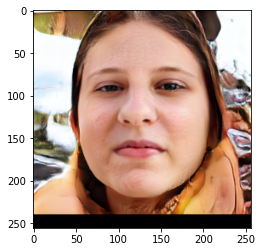

In [17]:
import matplotlib.pyplot as plt

plt.imshow(img_list[0][0]['p_img'][0].permute(1, 2, 0))

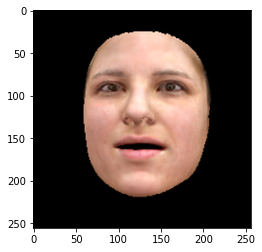

In [18]:
plt.imshow(img_list[0][0]['r_img'][0].permute(1, 2, 0))

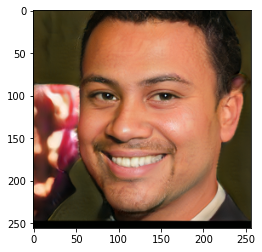

In [19]:
plt.imshow(img_list[1][0]['p_img'][0].permute(1, 2, 0))

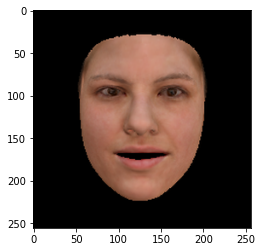

In [14]:
plt.imshow(img_list[0][1]['r_img'][0].permute(1, 2, 0))

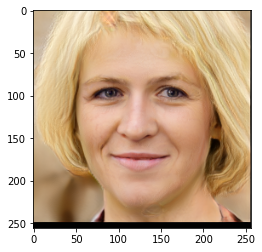

In [19]:
plt.imshow(img_list[1][0]['p_img'][1].permute(1, 2, 0))

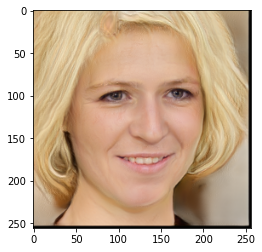

In [18]:
plt.imshow(img_list[1][1]['p_img'][1].permute(1, 2, 0))

In [9]:
img_list = []
i = 0
while True:
    data_batch = next(dl)
    if i ==0 or i == 200 or i==201:
        img_list.append(data_batch)
    if i % 20 ==0:
        print(i)
    if i == 202:
        break
    i += 1

0
20
40
60
80
100
120
140
160
180
stop iteration
200


In [10]:
len(img_list)

3

In [11]:
import torchvision.transforms as T
trsf = T.ToPILImage()

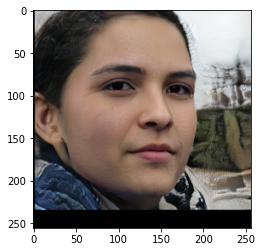

In [17]:
import matplotlib.pyplot as plt

plt.imshow(img_list[0][0]['p_img'][0].permute(1, 2, 0))

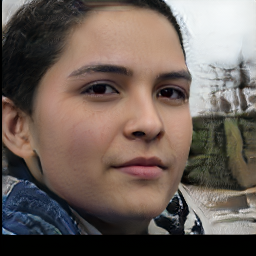

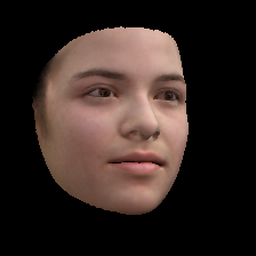

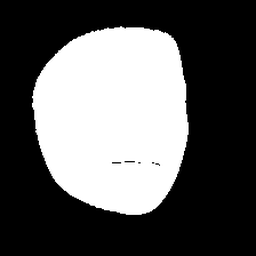

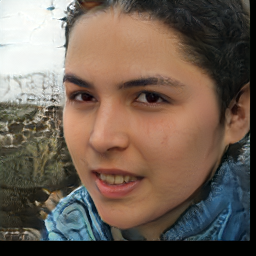

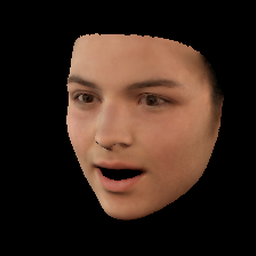

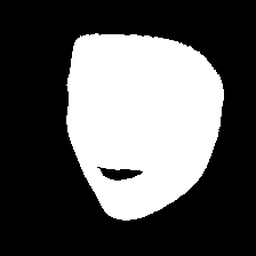

(None, None, None, None, None, None)

In [12]:
trsf(img_list[0][0]['p_img'][0]).show(), trsf(img_list[0][0]['r_img'][0]).show(), trsf(img_list[0][0]['m_img'][0]).show(), trsf(img_list[0][1]['p_img'][0]).show(), trsf(img_list[0][1]['r_img'][0]).show(), trsf(img_list[0][1]['m_img'][0]).show()

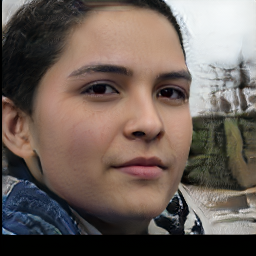

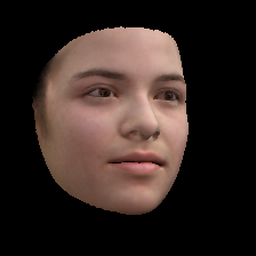

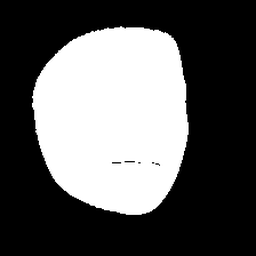

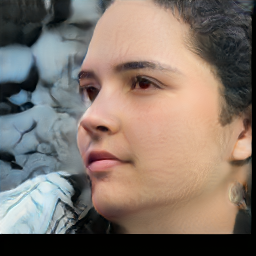

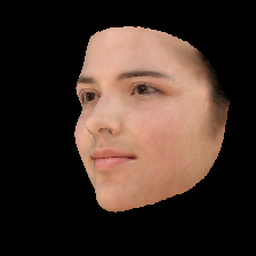

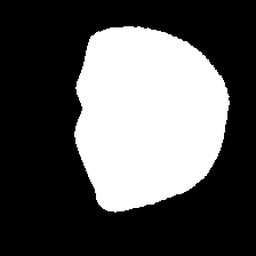

(None, None, None, None, None, None)

In [14]:
trsf(img_list[1][0]['p_img'][0]).show(), trsf(img_list[1][0]['r_img'][0]).show(), trsf(img_list[1][0]['m_img'][0]).show(), trsf(img_list[1][1]['p_img'][0]).show(), trsf(img_list[1][1]['r_img'][0]).show(), trsf(img_list[1][1]['m_img'][0]).show()

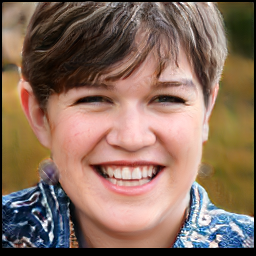

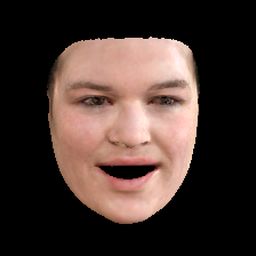

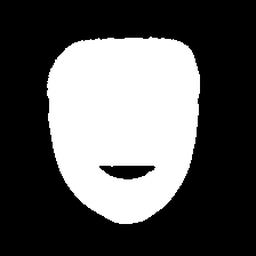

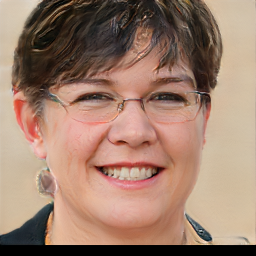

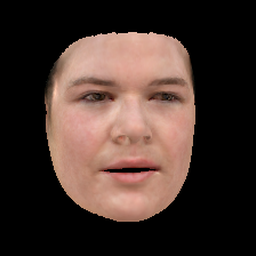

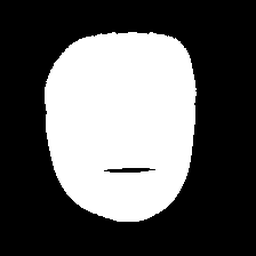

(None, None, None, None, None, None)

In [15]:
trsf(img_list[2][0]['p_img'][0]).show(), trsf(img_list[2][0]['r_img'][0]).show(), trsf(img_list[2][0]['m_img'][0]).show(), trsf(img_list[2][1]['p_img'][0]).show(), trsf(img_list[2][1]['r_img'][0]).show(), trsf(img_list[2][1]['m_img'][0]).show()

In [5]:
def sample_data(loader):
  while True:
    print('start')
    for batch in loader:
      yield batch

In [6]:
disen_ds = DisentangleDataset(root=cfg['dataset']['root'],
                                  sub_dir=cfg['dataset']['disen']['sub_dir'],
                                  crop=cfg['dataset']['disen']['crop'],
                                  resize_size=cfg['dataset']['disen']['resize'], 
                                  random_flip=cfg['dataset']['disen']['random_flip'])

In [7]:
dl = DataLoader(dataset=disen_ds, batch_size=48, shuffle=True, num_workers=16)

In [8]:
dl = sample_data(dl)

In [9]:
img_list = []
i = 0
while True:
    data_batch = next(dl)
    if i == 0 or i == 4375:
      img_list.append(data_batch)
    if i == 4376:
      break
    i += 1

start
start


In [10]:
len(img_list)

2

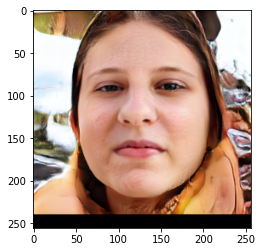

In [11]:
import matplotlib.pyplot as plt

plt.imshow(img_list[0][0]['p_img'][0].permute(1, 2, 0))

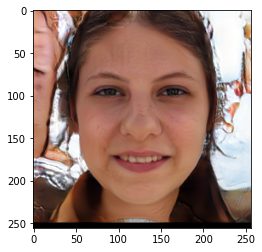

In [13]:
import matplotlib.pyplot as plt

plt.imshow(img_list[0][1]['p_img'][0].permute(1, 2, 0))

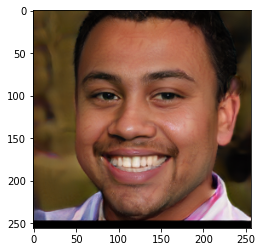

In [16]:
plt.imshow(img_list[1][1]['p_img'][0].permute(1, 2, 0))

In [8]:
img_list = []
i = 0
while True:
    data_batch = next(dl)
    if i ==0 or i == 200 or i==201:
        img_list.append(data_batch)
    if i % 20 ==0:
        print(i)
    if i == 202:
        break
    i += 1

0
20
40
60
80
100
120
140
160
180
200


In [9]:
import torchvision.transforms as T
trsf = T.ToPILImage()

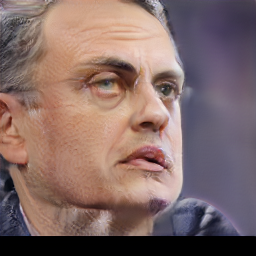

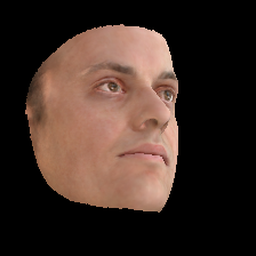

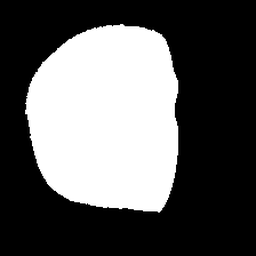

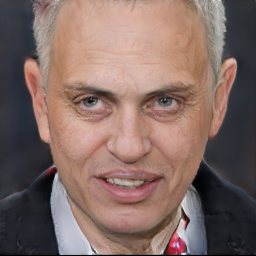

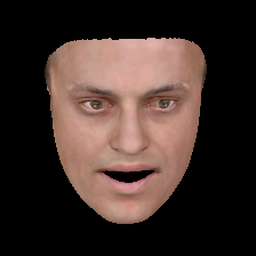

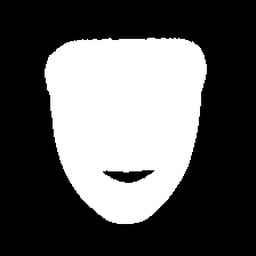

(None, None, None, None, None, None)

In [10]:
trsf(img_list[0][0]['p_img'][0]).show(), trsf(img_list[0][0]['r_img'][0]).show(), trsf(img_list[0][0]['m_img'][0]).show(), trsf(img_list[0][1]['p_img'][0]).show(), trsf(img_list[0][1]['r_img'][0]).show(), trsf(img_list[0][1]['m_img'][0]).show()

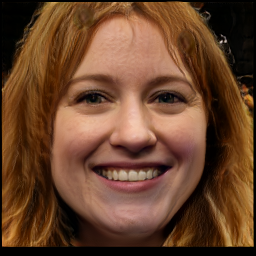

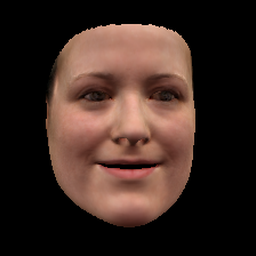

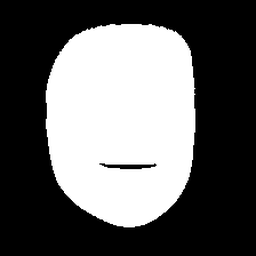

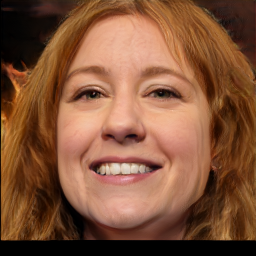

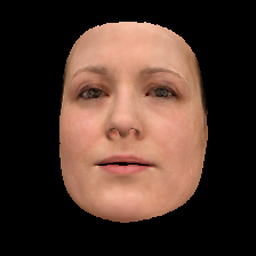

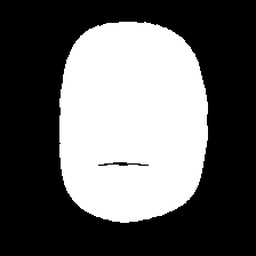

(None, None, None, None, None, None)

In [11]:
trsf(img_list[1][0]['p_img'][0]).show(), trsf(img_list[1][0]['r_img'][0]).show(), trsf(img_list[1][0]['m_img'][0]).show(), trsf(img_list[1][1]['p_img'][0]).show(), trsf(img_list[1][1]['r_img'][0]).show(), trsf(img_list[1][1]['m_img'][0]).show()

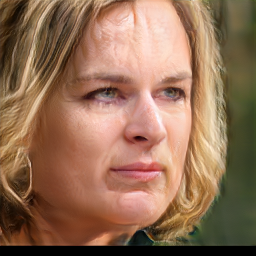

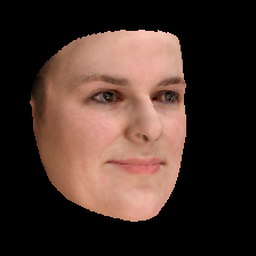

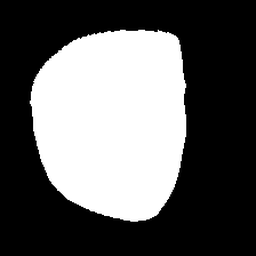

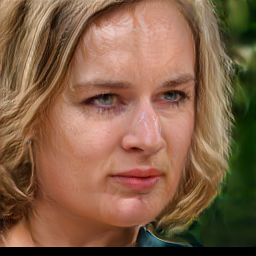

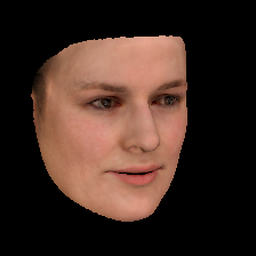

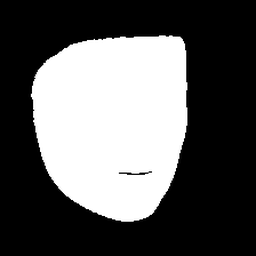

(None, None, None, None, None, None)

In [12]:
trsf(img_list[2][0]['p_img'][0]).show(), trsf(img_list[2][0]['r_img'][0]).show(), trsf(img_list[2][0]['m_img'][0]).show(), trsf(img_list[2][1]['p_img'][0]).show(), trsf(img_list[2][1]['r_img'][0]).show(), trsf(img_list[2][1]['m_img'][0]).show()

In [7]:
img_list = []
for idx, data in enumerate(dl):
  img_list.append(data)
  if idx == 10:
    break

In [20]:
import torchvision.transforms as T
trsf = T.ToPILImage()

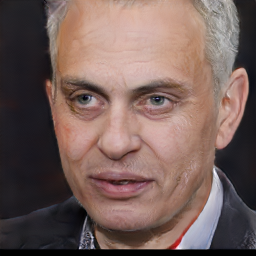

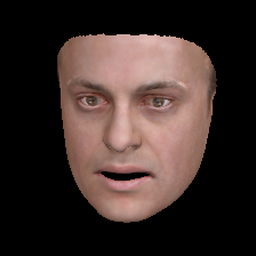

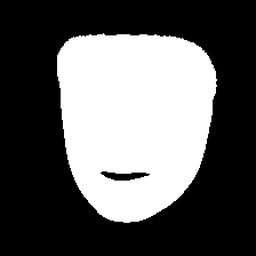

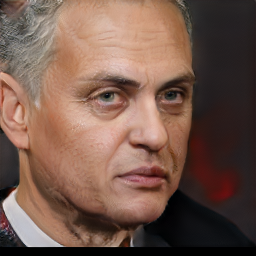

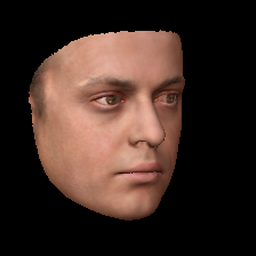

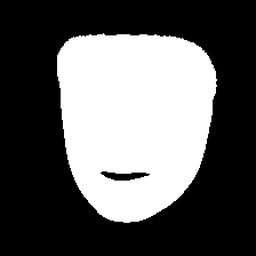

(None, None, None, None, None, None)

In [29]:
trsf(img_list[0][0]['p_img'][0]).show(), trsf(img_list[0][0]['r_img'][0]).show(), trsf(img_list[0][0]['m_img'][0]).show(), trsf(img_list[0][1]['p_img'][0]).show(), trsf(img_list[0][1]['r_img'][0]).show(), trsf(img_list[0][1]['m_img'][0]).show()

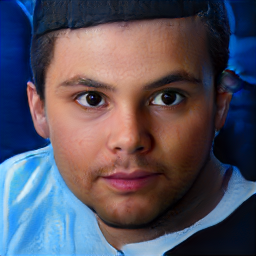

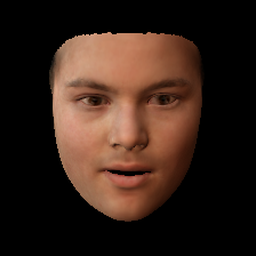

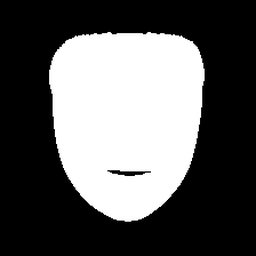

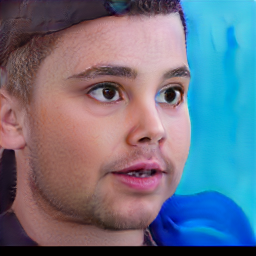

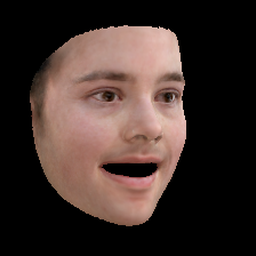

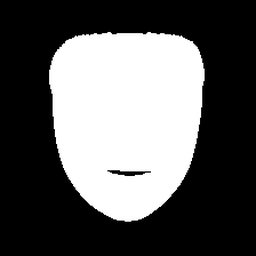

(None, None, None, None, None, None)

In [31]:
trsf(img_list[0][0]['p_img'][1]).show(), trsf(img_list[0][0]['r_img'][1]).show(), trsf(img_list[0][0]['m_img'][1]).show(), trsf(img_list[0][1]['p_img'][1]).show(), trsf(img_list[0][1]['r_img'][1]).show(), trsf(img_list[0][1]['m_img'][1]).show()